# Predicting Prices of Real Estate Listings
1. Business Understanding

Using the data gathered in the data wrangling notebook (scraped and wrangled from the Danish Real Estate Company Home). Let's try to predict the listing prices based on the features available.

## Questions
* Is it possible to predict listing prices based on characteristics of the home?
* If so, what features are most important?
* Which ones doesn't matter at all?

## Exploring the dataset
Before diving into the machine learning component let's learn a bit more about the data.

* Preparing the data
* Translating stuff
* Typecasting
* Plotting 


In [626]:
# Loading libraries
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sb
from sklearn import linear_model, tree, preprocessing, ensemble, model_selection
import os
import graphviz

In [ ]:
os.environ["PATH"] += os.pathsep + "C:\Program Files (x86)\Graphviz2.38\\bin"

In [338]:
df = pd.read_csv('home_data_clean_final.csv', index_col = 0)
df.reset_index(inplace = True)
df.head()

,index,Address,Area,City,HomeType,isNew,Latitude,Longitude,PostalCode,Price,...,Sewers,Basement,PriceDevelopment,Accessories,Heating,Windows,YearOfValuation,Exterior,NetOwnerFee,GrossOwnerFee
0,0,"A.D. Jørgensens Vej 75, 2. 1.",35.0,Frederiksberg,Ejerlejlighed,False,55.680726,12.494705,2000,1.350.000,...,NaN,NaN,-7%,Alle nuværende hårde hvidevarer i lejligheden ...,NaN,NaN,2018.0,NaN,5.249,4.628 kr.
1,1,"Holger Danskes Vej 14, 3. th.",46.0,Frederiksberg,Ejerlejlighed,False,55.686615,12.538356,2000,2.145.000,...,NaN,NaN,-6%,Intuition gaskomfur komfur - Matsui Fridge Do...,NaN,NaN,2018.0,NaN,8.313,7.331 kr.
2,11,"Lyøvej 5, st.. tv.",60.0,Frederiksberg,Ejerlejlighed,False,55.682940,12.524527,2000,2.875.000,...,NaN,NaN,-4%,emhætte - bordkomfur glaskeramisk - indbygni...,NaN,NaN,2018.0,NaN,10.446,9.212 kr.
3,12,"H. Schneekloths Vej 13, 5. th.",56.0,Frederiksberg,Ejerlejlighed,False,55.679928,12.506927,2000,2.750.000,...,NaN,NaN,0%,De i lejligheden hårde hvidevarer medfølger i ...,NaN,NaN,2018.0,NaN,10.075,8.884 kr.
4,30,"Howitzvej 61, 3. th.",67.0,Frederiksberg,Ejerlejlighed,True,55.680209,12.523998,2000,3.195.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [339]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8515 entries, 0 to 8514
Data columns (total 39 columns):
index                       8515 non-null int64
Address                     8515 non-null object
Area                        8505 non-null float64
City                        8515 non-null object
HomeType                    8515 non-null object
isNew                       8515 non-null bool
Latitude                    8221 non-null float64
Longitude                   8221 non-null float64
PostalCode                  8515 non-null int64
Price                       8515 non-null object
ID                          8515 non-null object
PaymentOnAccount            118 non-null object
DistanceToShopping          1227 non-null object
DistanceToTransportation    947 non-null object
DistanceToSchool            1013 non-null object
DistanceToForest            105 non-null object
DistanceToWater             338 non-null object
Balcony                     147 non-null object
Floors           

There's a large difference in number of missing values and some data types that are off. Price should definately be numeric for instance.

In [340]:
df['Price'].replace('\.', '', regex = True, inplace = True)
df['Price'] = df['Price'].astype('float64')

Furthermore it's clear that we have a very high data quality on a few columns, whereas the remaining are somewhat sparsely filled out. Let's check out the distribution of hometypes.

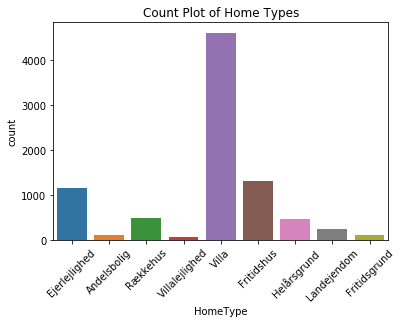

In [341]:
sb.countplot(data = df, x = 'HomeType')
plt.xticks(rotation = 45);
plt.title('Count Plot of Home Types');

Let's translate the categories to English.

In [342]:
df.HomeType = df.HomeType.str.replace('Ejerlejlighed', 'Apartment')
df.HomeType = df.HomeType.str.replace('Andelsbolig', 'Cooperative')
df.HomeType = df.HomeType.str.replace('Rækkehus', 'Row House')
df.HomeType = df.HomeType.str.replace('Villalejlighed', 'Garden apartment')
df.HomeType = df.HomeType.str.replace('Fritidshus', 'Cottage')
df.HomeType = df.HomeType.str.replace('Helårsgrund', 'Lot')
df.HomeType = df.HomeType.str.replace('Landejendom', 'Farmhouse') 
df.HomeType = df.HomeType.str.replace('Fritidsgrund', 'Cottage lot') #Excuse the English here: It's a piece of land reserved for cottage housing

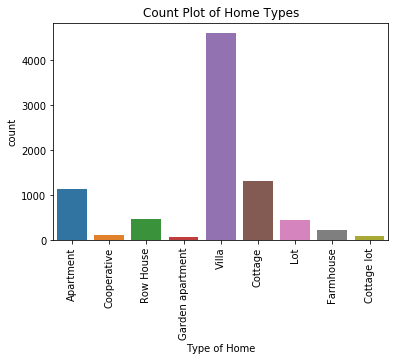

In [368]:
sb.countplot(data = df, x = 'HomeType')
plt.xticks(rotation = 90);
plt.xlabel('Type of Home')
plt.title('Count Plot of Home Types');

Turns out part of the dataset doesn't contain housing, but merely the lots. Let's keep that in mind for later!

Let's check out the distribution of prices

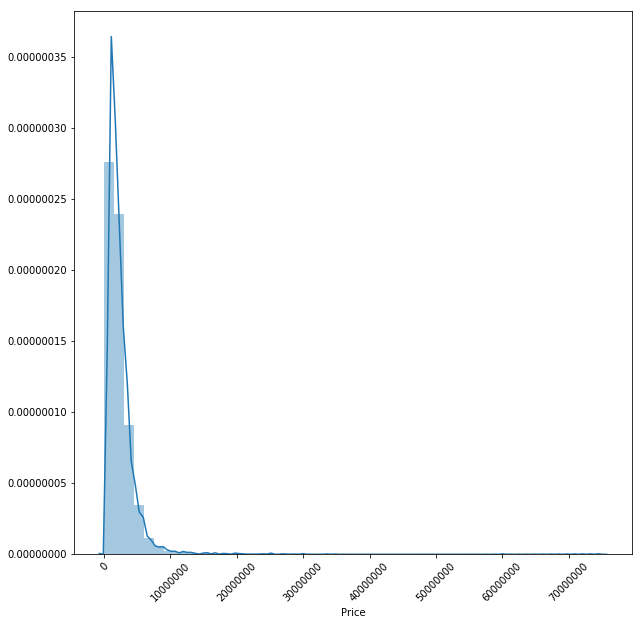

In [375]:
plt.figure(figsize = [10, 10])
sb.distplot(df.Price);
plt.xticks(rotation = 45) 
plt.ticklabel_format(style='plain')

Pretty right skewed - looks like we've got some expensive real estate (Prices are in DKK, for reference 1 USD ~ 7 DKK).
Let's look at a few:

In [469]:
df[df['Price'] > 30000000].head()

,index,Address,Area,City,HomeType,isNew,Latitude,Longitude,PostalCode,Price,...,Sewers,Basement,PriceDevelopment,Accessories,Heating,Windows,YearOfValuation,Exterior,NetOwnerFee,GrossOwnerFee
839,5384,Nybrovej 395,614.0,Kongens Lyngby,Villa,False,55.775475,12.461285,2800,60000000.0,...,Offentlig,NaN,-11%,Ingen,Kollektiv varmeforsyning/Solcellebaseret fjern...,NaN,2017.0,NaN,2.039,1.647 kr.
985,6390,"Tuborg Strand 1, 3., Tuborg Strandeng - Kysthus 1",250.0,Hellerup,Apartment,False,NaN,NaN,2900,33500000.0,...,NaN,35 m2,-5%,Bosch køle/fryseskab - knækket håndtag (fryser...,NaN,NaN,2017.0,NaN,6.987,6.125 kr.
986,6391,Lemchesvej 14,425.0,Hellerup,Villa,False,55.735103,12.578140,2900,35000000.0,...,NaN,NaN,0%,Siemens køleskab - Thermex emhætte - Siemens k...,NaN,NaN,2018.0,NaN,12.360,10.839 kr.
1059,6855,Vedbæk Strandvej 328,901.0,Vedbæk,Villa,False,55.842546,12.573132,2950,75000000.0,...,Afløb til spildevandsforsyningens renseanlæg,NaN,-11%,Zanussi køle-/fryseskabVoss komfurEcoline emhæ...,Fjernvarme,Træ-alu,2017.0,Pudset,3.143,2.712 kr.


Let's keep these four in mind - they may skew the eventual models we are to build.

Let's look at the area.

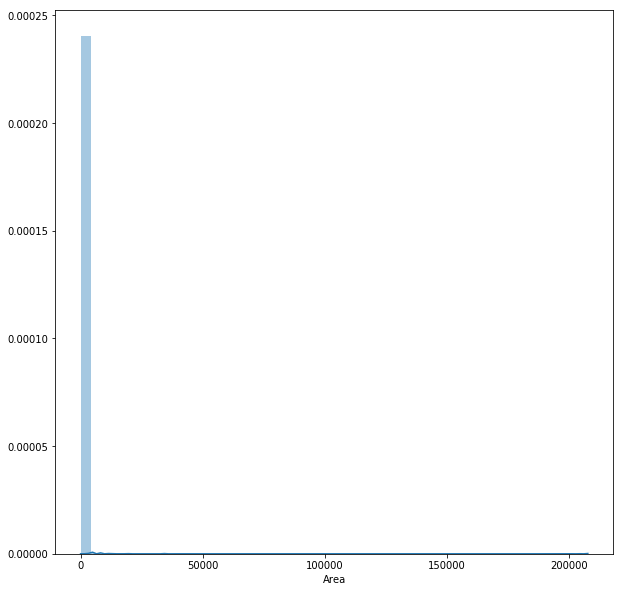

In [470]:
plt.figure(figsize = [10, 10])
sb.distplot(df.Area.dropna()); #Drop na in order to plot

Now that's not really that informative. Let's look at distribution of area for the different home types instead.

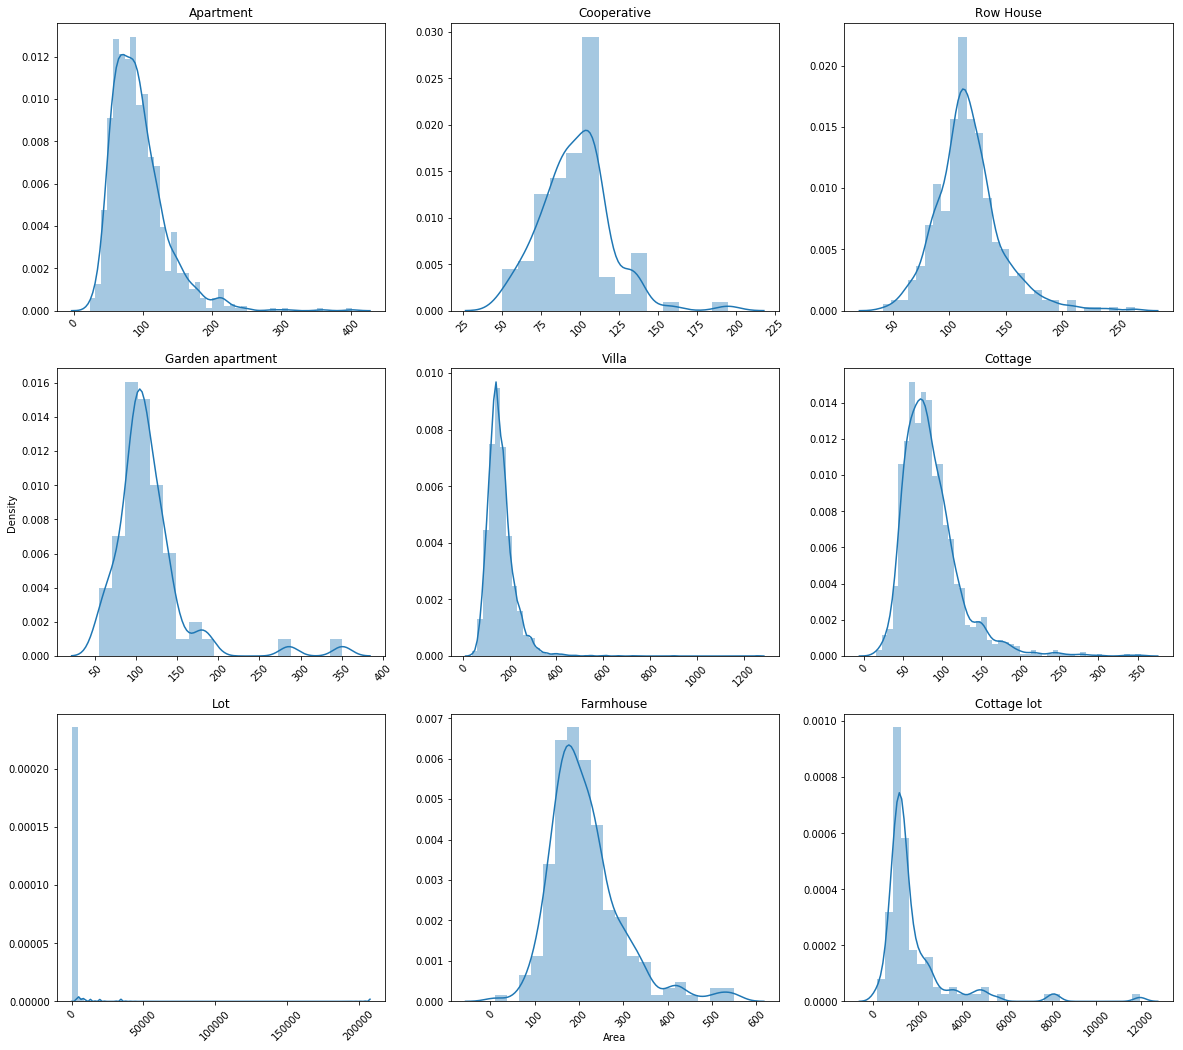

In [468]:
def subplot_distribution(df, loop_col, plot_col, drop_na):
    """
    Creates and plots subplots of distributions of plot_col for each column in loop_call.
    """
    unique_loop_col = df[loop_col].unique()
    
    total_subplots = len(unique_loop_col)
    count = 1
    if total_subplots // 3 == 3:
        x_label_center = True
    df_plot = df
    if drop_na:
        df_plot = df.loc[df[plot_col].dropna().index]
    plt.figure(figsize = [20, total_subplots*2]);
    for col in unique_loop_col:
        plt.subplot(math.ceil(total_subplots/3),3,count)
        try: 
            sb.distplot(df_plot[df_plot[loop_col] == col][plot_col])
        except:
            print('Failed to plot {}'.format(col)) 
        plt.xlabel('')
        plt.ticklabel_format(style='plain')
        plt.xticks(rotation = 45) 
        plt.title(col)
        if (x_label_center) & (count == total_subplots - 1):
            plt.xlabel(plot_col)
        elif (count == total_subplots) & ~(x_label_center):
            plt.xlabel(plot_col)          
        if count == 4:
            plt.ylabel('Density')
        count += 1
subplot_distribution(df, 'HomeType', 'Area', True)

Okay lot's of interesting takes here, but mainly the lot and the cottage lot are skewing our dataset with a few outliers.

Let's move on to the data as a whole.

How many rows do we have with data in all columns?

In [471]:
df.dropna()

,index,Address,Area,City,HomeType,isNew,Latitude,Longitude,PostalCode,Price,...,Sewers,Basement,PriceDevelopment,Accessories,Heating,Windows,YearOfValuation,Exterior,NetOwnerFee,GrossOwnerFee


Well that wasn't very encouraging. Let's try that again, but only with columns with more than 1000 rows of actual data.

In [472]:
complete_row_cols = df.columns[((df.shape[0]-df.isnull().sum()) > 1000)]
df_low_rows = df[complete_row_cols]
df_low_rows.head()

,index,Address,Area,City,HomeType,isNew,Latitude,Longitude,PostalCode,Price,...,LivingArea,YearOfConstruction,EstateValue,GroundArea,LandValue,PriceDevelopment,Accessories,YearOfValuation,NetOwnerFee,GrossOwnerFee
0,0,"A.D. Jørgensens Vej 75, 2. 1.",35.0,Frederiksberg,Apartment,False,55.680726,12.494705,2000,1350000.0,...,35 m2,1991.0,780.000,NaN,168.300,-7%,Alle nuværende hårde hvidevarer i lejligheden ...,2018.0,5.249,4.628 kr.
1,1,"Holger Danskes Vej 14, 3. th.",46.0,Frederiksberg,Apartment,False,55.686615,12.538356,2000,2145000.0,...,46 m2,1885.0,1.100.000,NaN,145.000,-6%,Intuition gaskomfur komfur - Matsui Fridge Do...,2018.0,8.313,7.331 kr.
2,11,"Lyøvej 5, st.. tv.",60.0,Frederiksberg,Apartment,False,55.682940,12.524527,2000,2875000.0,...,77 m2,1988.0,1.600.000,NaN,259.100,-4%,emhætte - bordkomfur glaskeramisk - indbygni...,2018.0,10.446,9.212 kr.
3,12,"H. Schneekloths Vej 13, 5. th.",56.0,Frederiksberg,Apartment,False,55.679928,12.506927,2000,2750000.0,...,74 m2,1972.0,1.350.000,NaN,164.300,0%,De i lejligheden hårde hvidevarer medfølger i ...,2018.0,10.075,8.884 kr.
4,30,"Howitzvej 61, 3. th.",67.0,Frederiksberg,Apartment,True,55.680209,12.523998,2000,3195000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [316]:
df_low_rows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8515 entries, 0 to 8514
Data columns (total 26 columns):
index                 8515 non-null int64
Address               8515 non-null object
Area                  8505 non-null float64
City                  8515 non-null object
HomeType              8515 non-null object
isNew                 8515 non-null bool
Latitude              8221 non-null float64
Longitude             8221 non-null float64
PostalCode            8515 non-null int64
Price                 8515 non-null float64
ID                    8515 non-null object
DistanceToShopping    1227 non-null object
DistanceToSchool      1013 non-null object
Floors                1077 non-null float64
Rooms                 1322 non-null float64
Toilets               1021 non-null object
LivingArea            1330 non-null object
YearOfConstruction    1327 non-null float64
EstateValue           1268 non-null object
GroundArea            1093 non-null object
LandValue             1267 non

In [473]:
df_low_rows.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428 entries, 84 to 1439
Data columns (total 26 columns):
index                 428 non-null int64
Address               428 non-null object
Area                  428 non-null float64
City                  428 non-null object
HomeType              428 non-null object
isNew                 428 non-null bool
Latitude              428 non-null float64
Longitude             428 non-null float64
PostalCode            428 non-null int64
Price                 428 non-null float64
ID                    428 non-null object
DistanceToShopping    428 non-null object
DistanceToSchool      428 non-null object
Floors                428 non-null float64
Rooms                 428 non-null float64
Toilets               428 non-null object
LivingArea            428 non-null object
YearOfConstruction    428 non-null float64
EstateValue           428 non-null object
GroundArea            428 non-null object
LandValue             428 non-null object
PriceDev

In [474]:
df.columns

Index(['index', 'Address', 'Area', 'City', 'HomeType', 'isNew', 'Latitude',
       'Longitude', 'PostalCode', 'Price', 'ID', 'PaymentOnAccount',
       'DistanceToShopping', 'DistanceToTransportation', 'DistanceToSchool',
       'DistanceToForest', 'DistanceToWater', 'Balcony', 'Floors', 'Rooms',
       'Toilets', 'Connection', 'LivingArea', 'YearOfConstruction',
       'EstateValue', 'EnergyRating', 'Level', 'GroundArea', 'LandValue',
       'Sewers', 'Basement', 'PriceDevelopment', 'Accessories', 'Heating',
       'Windows', 'YearOfValuation', 'Exterior', 'NetOwnerFee',
       'GrossOwnerFee'],
      dtype='object')

Alright! Not the largest number of rows, but we at least got some data to work with.

We have some options at this point:
1. Only use the columns with a high quality
1. Discard the some of the outliers
2. Use all columns and all rows and use the lack of information as a category for the lacking columns
3. Drop rows with missing values to accomodate the features with a lower quality

Before we start with the modelling, let's just enjoy the following plot.

In the data we have the latitude and longitude of all the listings, so we can plot them along with the prices to create a map of the listings in Denmark!

First, here's a picture for reference.

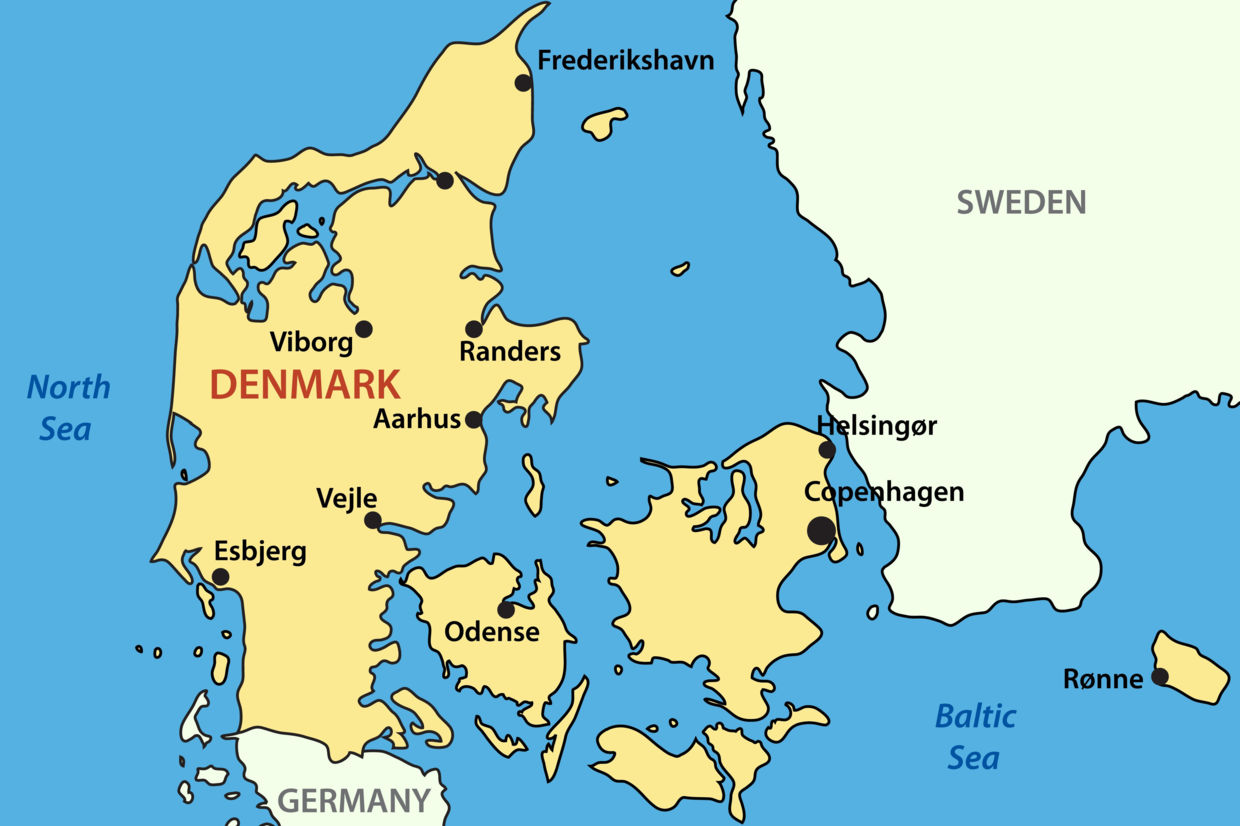

In [491]:
from IPython.display import Image
Image("img/denmark.jpeg")

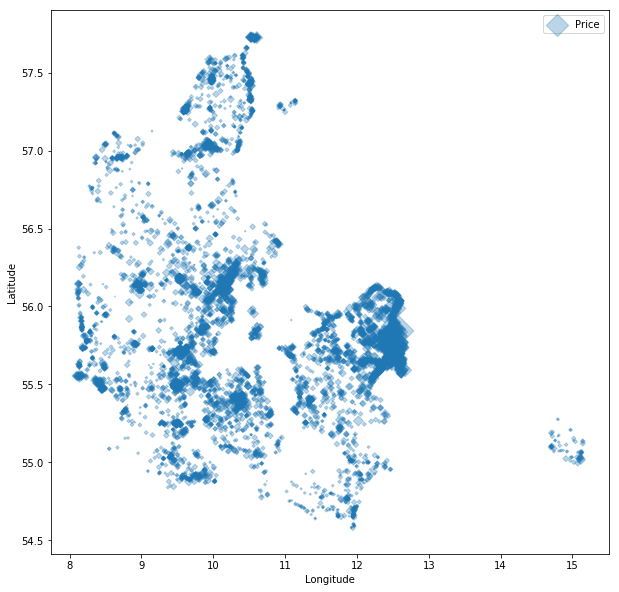

In [486]:
scale = (df['Price']/df['Price'].max()) * 500 # abbritary number for the scale
plt.figure(figsize = [10, 10])
plt.scatter(data = df, x = 'Longitude', y = 'Latitude', s = scale, alpha = 0.3, marker = 'D')
plt.legend({'Price'});
plt.xlabel('Longitude');
plt.ylabel('Latitude');

Look at this thing! It's beautiful, if I do say so myself. But not only that, it also provides indication of a trend.
It looks like the areas arround Århus, Copenhagen and Odense have the largest density of listings (this is unsurpricing), but Copenhagen appears to have the highest prices with a few oddballs here an there. So there's definetly a regional component to the pricing.

In [ ]:
df

In [505]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1),
                            pd.get_dummies(df[col], 
                                           prefix=col, 
                                           prefix_sep='_', 
                                           drop_first=True, 
                                           dummy_na=dummy_na)], 
                           axis=1)
        except:
            continue
    return df

In [583]:
mini_df = df[['Price','Area','PostalCode','HomeType', 'Latitude', 'Longitude']].dropna(axis = 0, how = 'any')
#mini_df = create_dummy_df(mini_df,['HomeType','PostalCode'], False)
mini_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8211 entries, 0 to 8514
Data columns (total 6 columns):
Price         8211 non-null float64
Area          8211 non-null float64
PostalCode    8211 non-null int64
HomeType      8211 non-null object
Latitude      8211 non-null float64
Longitude     8211 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 449.0+ KB


In [584]:
mini_df.HomeType.unique()

array(['Apartment', 'Cooperative', 'Row House', 'Garden apartment',
       'Villa', 'Cottage', 'Lot', 'Farmhouse', 'Cottage lot'],
      dtype=object)

In [585]:
le = preprocessing.LabelEncoder()
le.fit(mini_df.HomeType.unique())

LabelEncoder()

In [586]:
mini_df['HomeType_cat'] = le.transform(mini_df.HomeType)
mini_df[['Area','HomeType_cat']].head()

,Area,HomeType_cat
0,35.0,0
1,46.0,0
2,60.0,0
3,56.0,0
4,67.0,0


In [587]:
mini_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8211 entries, 0 to 8514
Data columns (total 7 columns):
Price           8211 non-null float64
Area            8211 non-null float64
PostalCode      8211 non-null int64
HomeType        8211 non-null object
Latitude        8211 non-null float64
Longitude       8211 non-null float64
HomeType_cat    8211 non-null int32
dtypes: float64(4), int32(1), int64(1), object(1)
memory usage: 481.1+ KB


In [618]:
X = mini_df[['Area','HomeType_cat','PostalCode','Longitude','Latitude']]
y = mini_df.Price

In [610]:

clf = tree.DecisionTreeRegressor(max_depth = 10)
clf.fit(X, y)
clf.score(X,y)

0.8302962855406956

In [651]:
df_low_rows.head(1)

,index,Address,Area,City,HomeType,isNew,Latitude,Longitude,PostalCode,Price,...,LivingArea,YearOfConstruction,EstateValue,GroundArea,LandValue,PriceDevelopment,Accessories,YearOfValuation,NetOwnerFee,GrossOwnerFee
0,0,"A.D. Jørgensens Vej 75, 2. 1.",35.0,Frederiksberg,Apartment,False,55.680726,12.494705,2000,1350000.0,...,35 m2,1991.0,780.000,NaN,168.300,-7%,Alle nuværende hårde hvidevarer i lejligheden ...,2018.0,5.249,4.628 kr.


In [656]:
minier_df = df_low_rows.dropna()
minier_df['HomeType_cat'] = le.transform(minier_df.HomeType)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [659]:
X = minier_df[['Area','HomeType_cat','PostalCode','Longitude','Latitude','Floors']]
y = minier_df['Price']

In [662]:
regr = ensemble.RandomForestRegressor(random_state=42, n_estimators=20
                             ,max_depth=10)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=42)
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [663]:
regr.score(X_test,y_test)

0.6497512431566295

In [647]:
regr = ensemble.RandomForestRegressor(random_state=42, n_estimators=1000)
                             #max_depth=100)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=42)
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [648]:
regr.score(X_test, y_test)

0.6467184430957966

In [649]:
regr.estimators_[2]

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=1935803228, splitter='best')

In [620]:
regr.feature_importances_

array([0.49832806, 0.03409832, 0.26516274, 0.11287331, 0.08953757])

In [ ]:
# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

In [625]:
regr.predict([[80,0,8000,55.6861487,12.5506125]])

array([1872108.13077782])

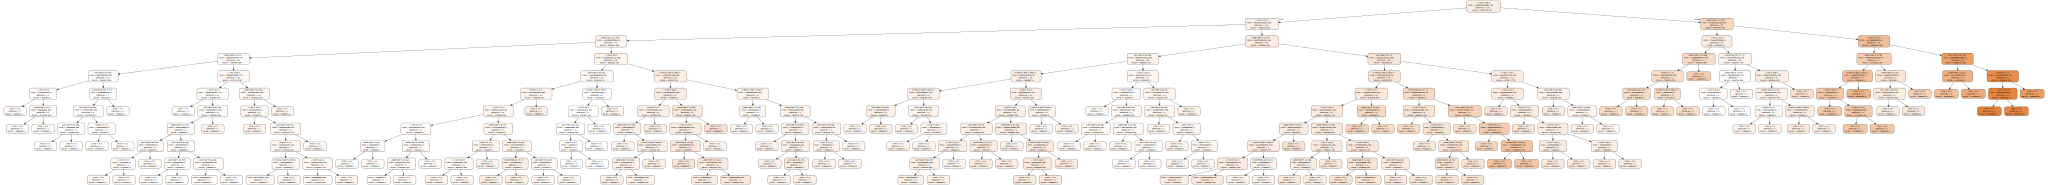

In [664]:
dot_data = tree.export_graphviz(regr.estimators_[2], out_file=None, 
                      feature_names=['Area','HomeType_cat','PostalCode','Longitude','Latitude','Floors'],  
                      #class_names=iris.target_names,  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 



In [608]:
clf.predict([[91,0,8000]])

array([3453200.])

In [609]:
clf.feature_importances_

array([0.59575922, 0.03840624, 0.36583455])

In [600]:
le.inverse_transform([0])

array(['Apartment'], dtype=object)

In [511]:

y = mini_df['Price']
X = mini_df.drop(columns = ['Price'])
reg = linear_model.LinearRegression()
log_reg = linear_model.LogisticRegression(random_state=0, solver='lbfgs',
                          multi_class='multinomial')
log_reg.fit(X, y)
reg.fit(X, y)

reg.score(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.505633718805195

In [512]:
log_reg.score(X, y)

0.026062598952624527

In [513]:
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X, y)
clf.score(X,y)

0.9999530202686845

In [ ]:

dot_data = tree.export_graphviz(clf, out_file=None, 
                      #feature_names=iris.feature_names,  
                      #class_names=iris.target_names,  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 



In [124]:
reg = linear_model.LinearRegression()
lol = (homes[['Longitude', 'Latitude', 'Area', 'Price']].dropna(axis = 0, how = 'any'))
X = lol[['Longitude', 'Latitude', 'Area']]
y = lol['Price']
reg.fit(X, y)
lol.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7702 entries, 0 to 51069
Data columns (total 4 columns):
Longitude    7702 non-null float64
Latitude     7702 non-null float64
Area         7702 non-null float64
Price        7702 non-null float64
dtypes: float64(4)
memory usage: 300.9 KB


In [125]:
reg.score(X, y)

0.27524659233581583

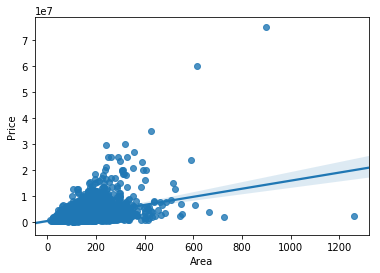

In [126]:
sb.regplot(x = lol['Area'], y = lol['Price']);

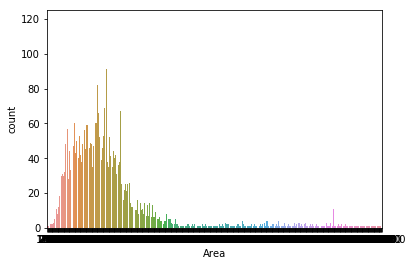

In [93]:
sb.countplot(lol.Area);

In [95]:
lol.describe()

,Longitude,Latitude,Area,Price
count,8211.000000,8211.000000,8211.000000,8.211000e+03
mean,10.614271,55.882814,236.270125,2.333138e+06
std,1.336977,0.665187,2360.100562,2.367122e+06
min,8.095746,54.574901,11.000000,9.888000e+03
25%,9.634699,55.476058,96.000000,1.095000e+06
50%,10.335854,55.733185,134.000000,1.795000e+06
75%,11.896685,56.141279,179.000000,2.895000e+06
max,15.146179,57.737277,207593.000000,7.500000e+07


In [96]:
df.query('Area == 207593')

,Address,Area,City,HomeType,isNew,Latitude,Longitude,PostalCode,Price,ID,...,Sewers,Basement,PriceDevelopment,Accessories,Heating,Windows,YearOfValuation,Exterior,NetOwnerFee,GrossOwnerFee
41399,Båstrupvej 15,207593.0,Skanderborg,Helårsgrund,False,55.998895,9.948583,8660,4495000.0,607-01623,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
df.loc[41399]

Address                     Båstrupvej 15
Area                               207593
City                          Skanderborg
HomeType                      Helårsgrund
isNew                               False
Latitude                          55.9989
Longitude                         9.94858
PostalCode                           8660
Price                           4.495e+06
ID                              607-01623
PaymentOnAccount                      NaN
DistanceToShopping                    NaN
DistanceToTransportation              NaN
DistanceToSchool                      NaN
DistanceToForest                      NaN
DistanceToWater                       NaN
Balcony                               NaN
Floors                                NaN
Rooms                                 NaN
Toilets                               NaN
Connection                            NaN
LivingArea                            NaN
YearOfConstruction                    NaN
EstateValue                       

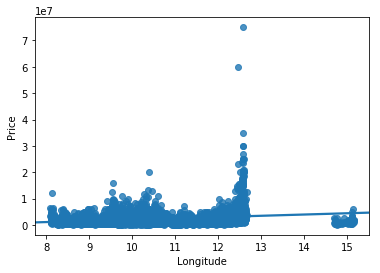

In [69]:
sb.regplot(x = lol['Longitude'], y = lol['Price']);
sb.regplot(x = lol['Longitude'], y = lol['Price']);
1
sb.regplot(x = lol['Longitude'], y = lol['Price']);

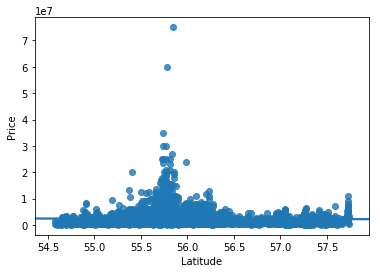

In [72]:
sb.regplot(x = lol['Latitude'], y = lol['Price']);

In [73]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8515 entries, 0 to 51069
Data columns (total 38 columns):
Address                     8515 non-null object
Area                        8505 non-null float64
City                        8515 non-null object
HomeType                    8515 non-null object
isNew                       8515 non-null bool
Latitude                    8221 non-null float64
Longitude                   8221 non-null float64
PostalCode                  8515 non-null int64
Price                       8515 non-null float64
ID                          8515 non-null object
PaymentOnAccount            118 non-null object
DistanceToShopping          1227 non-null object
DistanceToTransportation    947 non-null object
DistanceToSchool            1013 non-null object
DistanceToForest            105 non-null object
DistanceToWater             338 non-null object
Balcony                     147 non-null object
Floors                      1077 non-null float64
Rooms        

In [215]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1),
                            pd.get_dummies(df[col], 
                                           prefix=col, 
                                           prefix_sep='_', 
                                           drop_first=True, 
                                           dummy_na=dummy_na)], 
                           axis=1)
        except:
            continue
    return df

In [216]:
df.head()

,index,Address,Area,City,HomeType,isNew,Latitude,Longitude,PostalCode,Price,...,Sewers,Basement,PriceDevelopment,Accessories,Heating,Windows,YearOfValuation,Exterior,NetOwnerFee,GrossOwnerFee
0,0,"A.D. Jørgensens Vej 75, 2. 1.",35.0,Frederiksberg,Apartment,False,55.680726,12.494705,2000,1350000.0,...,NaN,NaN,-7%,Alle nuværende hårde hvidevarer i lejligheden ...,NaN,NaN,2018.0,NaN,5.249,4.628 kr.
1,1,"Holger Danskes Vej 14, 3. th.",46.0,Frederiksberg,Apartment,False,55.686615,12.538356,2000,2145000.0,...,NaN,NaN,-6%,Intuition gaskomfur komfur - Matsui Fridge Do...,NaN,NaN,2018.0,NaN,8.313,7.331 kr.
2,11,"Lyøvej 5, st.. tv.",60.0,Frederiksberg,Apartment,False,55.682940,12.524527,2000,2875000.0,...,NaN,NaN,-4%,emhætte - bordkomfur glaskeramisk - indbygni...,NaN,NaN,2018.0,NaN,10.446,9.212 kr.
3,12,"H. Schneekloths Vej 13, 5. th.",56.0,Frederiksberg,Apartment,False,55.679928,12.506927,2000,2750000.0,...,NaN,NaN,0%,De i lejligheden hårde hvidevarer medfølger i ...,NaN,NaN,2018.0,NaN,10.075,8.884 kr.
4,30,"Howitzvej 61, 3. th.",67.0,Frederiksberg,Apartment,True,55.680209,12.523998,2000,3195000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [233]:
mini_df = df[['Price','Area','PostalCode','HomeType']].dropna(axis = 0, how = 'any')
mini_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8505 entries, 0 to 8514
Data columns (total 4 columns):
Price         8505 non-null float64
Area          8505 non-null float64
PostalCode    8505 non-null int64
HomeType      8505 non-null object
dtypes: float64(2), int64(1), object(1)
memory usage: 332.2+ KB


In [234]:
mini_df.HomeType.unique()

array(['Apartment', 'Cooperative', 'Row House', 'Garden apartment',
       'Villa', 'Cottage', 'Lot', 'Lotejendom', 'Cottage lot'],
      dtype=object)

In [235]:
mini_df = create_dummy_df(mini_df,['HomeType','PostalCode'], False)
mini_df.head()

,Price,Area,HomeType_Cooperative,HomeType_Cottage,HomeType_Cottage lot,HomeType_Garden apartment,HomeType_Lot,HomeType_Lotejendom,HomeType_Row House,HomeType_Villa,...,PostalCode_9830,PostalCode_9850,PostalCode_9870,PostalCode_9881,PostalCode_9900,PostalCode_9940,PostalCode_9970,PostalCode_9981,PostalCode_9982,PostalCode_9990
0,1350000.0,35.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2145000.0,46.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2875000.0,60.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2750000.0,56.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3195000.0,67.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [237]:
mini_df.HomeType_Appartment

AttributeError: 'DataFrame' object has no attribute 'HomeType_Appartment'

In [280]:
reg = linear_model.LinearRegression()
y = mini_df['Price']
X = mini_df.drop(columns = ['Price'])

reg.fit(X, y)
reg.score(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [226]:
reg.score(X, y)

0.5056473280511324

In [ ]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    Perform to obtain the correct X and y objects
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no salaries
    2. Create X as all the columns that are not the Salary column
    3. Create y as the Salary column
    4. Drop the Salary, Respondent, and the ExpectedSalary columns from X
    5. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    df_copy = df.copy()
    df_copy.dropna(axis=0, subset =['Salary'], inplace = True)
    X = df_copy.drop(columns=['Salary'])
    y = df_copy['Salary']
    X.drop(columns=['Respondent','ExpectedSalary'], inplace=True)
    
    cat_cols = X.select_dtypes(include='object', exclude=None)
    num_cols = list(X.select_dtypes(include=['float','int'], exclude=None).columns) 
    cat_vars = cat_vars = X.select_dtypes(include=['object']).copy().columns
    #X = pd.concat([X, pd.get_dummies(cat_cols, drop_first=True)], axis=1)
    for var in cat_vars:
        # for each cat add dummy var, drop original column
        X = pd.concat([X.drop(var, axis=1), pd.get_dummies(X[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    #X.drop(columns=list(cat_cols.columns), inplace=True)
    print(X.shape)
    fill_means = lambda col: col.fillna(col.mean())
    X[num_cols] = X[num_cols].apply(fill_means)
    return X, y
    
#Use the function to create X and y
X, y = clean_data(df)    
X.shape

In [ ]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)